In [1]:
!pip install bokeh


In [2]:
import pandas as pd
from google.colab import files
import io

uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['dataset.csv']))
df.head()


Saving dataset.csv to dataset.csv


,ID,SystemCodeNumber,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,LastUpdatedDate,LastUpdatedTime
0,0,BHMBCCMKT01,577,26.144536,91.736172,61,car,low,1,0,04-10-2016,07:59:00
1,1,BHMBCCMKT01,577,26.144536,91.736172,64,car,low,1,0,04-10-2016,08:25:00
2,2,BHMBCCMKT01,577,26.144536,91.736172,80,car,low,2,0,04-10-2016,08:59:00
3,3,BHMBCCMKT01,577,26.144536,91.736172,107,car,low,2,0,04-10-2016,09:32:00
4,4,BHMBCCMKT01,577,26.144536,91.736172,150,bike,low,2,0,04-10-2016,09:59:00


In [3]:
df.rename(columns={
    'SystemCodeNumber': 'Location_ID',
    'VehicleType': 'Vehicle_Type',
    'TrafficConditionsNearby': 'Traffic',
    'LastUpdatedDate': 'Date',
    'LastUpdatedTime': 'Time'
}, inplace=True)

In [4]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource
from bokeh.io import push_notebook
import time

output_notebook()


In [6]:
lot_df = df[df['Location_ID'] == df['Location_ID'].unique()[0]].copy()
lot_df = lot_df.sort_values(by=['Date', 'Time']).reset_index(drop=True)

from bokeh.layouts import column

source = ColumnDataSource(data=dict(x=[], y=[]))

p = figure(title="⏱️ Real-Time Parking Price", x_axis_label='Time', y_axis_label='Price ($)',
           width=800, height=400, x_range=[])

p.line(x='x', y='y', source=source, line_width=2, legend_label='Demand-Based Price', color='orange')
p.legend.location = 'top_left'

In [9]:
def get_price(row, base_price=10):
    occ = row['Occupancy']
    cap = row['Capacity']
    queue = row['QueueLength']
    traffic = {'low': 0, 'medium': 1, 'high': 2}.get(row['TrafficConditionNearby'], 1)
    special = row['IsSpecialDay']
    vehicle = {'car': 1, 'bike': 0.5, 'truck': 1.5}.get(row['Vehicle_Type'], 1)

    demand = (1 * (occ / cap)) + (0.5 * queue) - (0.7 * traffic) + (2 * special) + vehicle
    norm_demand = (demand - 0.5) / (5.5 - 0.5)  # Normalize between 0–1
    price = base_price * (1 + 0.3 * norm_demand)
    return round(min(max(price, 5), 20), 2)

KeyboardInterrupt: 

/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)


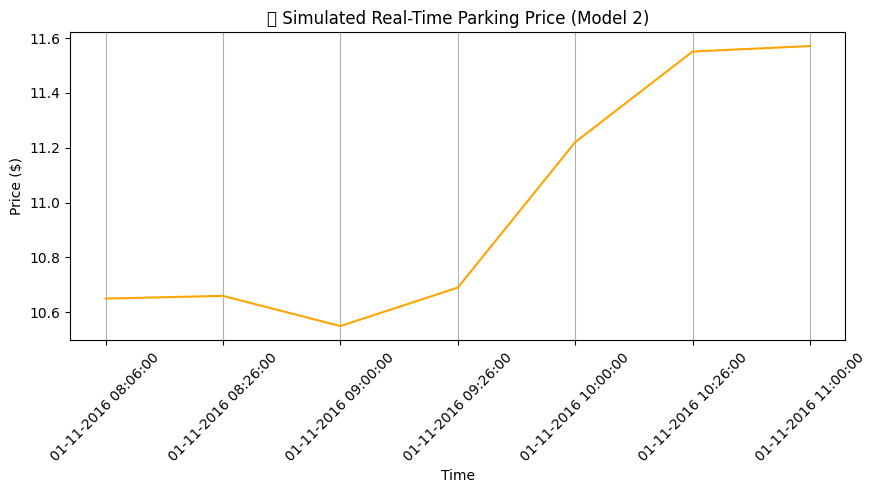

In [17]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

timestamps = []
prices = []

for i in range(len(lot_df)):
    row = lot_df.iloc[i]
    timestamp = f"{row['Date']} {row['Time']}"
    price = get_price(row)

    timestamps.append(timestamp)
    prices.append(price)

    clear_output(wait=True)
    plt.figure(figsize=(10, 4))
    plt.plot(timestamps, prices, color='orange', label='Demand-Based Price')
    plt.title("⏱️ Simulated Real-Time Parking Price (Model 2)")
    plt.xlabel("Time")
    plt.ylabel("Price ($)")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    time.sleep(0.5)  # 50ms delay to simulate speed
